## Imports

In [14]:
import gym
# import gym_minigrid
from gym_minigrid.wrappers import *
import time
import pickle
from os.path import exists
# import random
import functools
import numpy as np
import pandas as pd
import time
import logging
import matplotlib.pyplot as plt
# import typing

logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)


def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        logging.debug(f"Starting {func.__name__!r}.")
        start_time = time.perf_counter()
        value = func(*args, **kwargs)
        end_time = time.perf_counter()
        run_time = end_time - start_time
        logging.debug(f"Finished {func.__name__!r} in {run_time:.4f} secs.")
        return value
    return wrapper_timer


@timer
def reshape_state(state: np.ndarray) -> np.ndarray:
    (rows, cols, x) = state.shape
    _ = np.reshape(state, [rows*cols*x, 1], 'F')[0:rows*cols]
    state_reshaped = np.reshape(_, [rows, cols], 'F')
    return state_reshaped


@timer
def generate_state_hash(arr: np.ndarray) -> int:
    return abs(hash(arr.tobytes()))


@timer
def initialise_env(env_vars) -> np.ndarray:
    env = gym.make(env_vars['ENV_NAME'])
    env = ImgObsWrapper(env)
    return env


@timer
def initialise_state(env):
    _ = env.reset()
    _state = reshape_state(_)
    state = generate_state_hash(_state)
    return state


@timer
def take_random_action(env_vars):
    """
    left = 0
    right = 1
    forward = 2
    """
    return np.random.randint(0, env_vars['possible_actions'])


@timer
def take_action_epsilon_greedy(q_table, state, env_vars, epsilon):
    if (np.random.random() < epsilon):
        action = take_random_action(env_vars)
    else:
        action = np.argmax(q_table[state])
    logging.debug(f"Action chosen: {action}")
    return action


@timer
def initialise_q(env_vars, state):
    q = {}
    val = np.full((env_vars['possible_actions'],), env_vars['init_q_val'])
    q[state] = val
    return q


def create_grid(env_vars):
    grid = {}
    key = 0
    for i in range(len(env_vars['alpha_range'])):
        for j in range(len(env_vars['gamma_range'])):
            grid[key] = {'alpha': env_vars['alpha_range'][i],
                         'gamma': env_vars['gamma_range'][j]}
            key = key + 1
    logging.info(f"Grid: {grid}")
    return grid


def update_epsilon(env_vars: dict, prev_epsilon: float, episode: int) -> float:
    if prev_epsilon > env_vars['min_epsilon']:
        epsilon = prev_epsilon * env_vars['epsilon_decay_rate']
    else:
        epsilon = env_vars['min_epsilon']
    return epsilon


@timer
def train(env_vars, hparams):
    env = initialise_env(env_vars)
    state = initialise_state(env)
    q = initialise_q(env_vars, state)
    rewards = []
    step_tracker = []
    prev_epsilon = env_vars['max_epsilon']  # Initalise epsilon to max_value
    for episode in range(env_vars['EPISODES']):
        state = initialise_state(env)
        epsilon = update_epsilon(env_vars, prev_epsilon, episode)
        for step in range(0, env_vars['MAX_STEPS']):
            action = take_action_epsilon_greedy(q, state, env_vars, epsilon)
            _next_state, reward, done, info = env.step(action)
#             env.render() # render the environment, this does not work inside Jupyter notebook
#             time.sleep(0.05) # When training without rendering remove this line
            if done:
                if reward > 0:
                    step_tracker.append(step)
                    logging.debug(
                        f"Finished episode successfully taking {step} steps and receiving reward {reward}")
                else:
                    pass
                break
            _next_state = reshape_state(_next_state)
            next_state = generate_state_hash(_next_state)
            if q.get(next_state) is None:
                val = np.full(
                    (env_vars['possible_actions'],), env_vars['init_q_val'])
                q[next_state] = val
            next_action = np.argmax(q[next_state])
            q[state][action] = q[state][action] + hparams['alpha'] * \
                (reward + hparams['gamma'] * (q[next_state]
                 [next_action]) - q[state][action])
            state = next_state
        rewards.append(reward)
        prev_epsilon = epsilon  # Update epsilon so that it can decay
    agent_name = f'agent_{int(time.time())}'
    _save_agent(env_vars, q, agent_name)
    plot_reward(env_vars, rewards, agent_name)
    result = {'alpha': hparams['alpha'],
              'gamma': hparams['gamma'],
              'min_epsilon': env_vars['min_epsilon'],
              'max_epsilon': env_vars['max_epsilon'],
              'epsilon_decay_rate': env_vars['epsilon_decay_rate'],
              'avg_reward': np.sum(rewards) / np.count_nonzero(rewards),
              'completion_rate': np.count_nonzero(rewards) / len(rewards),
              'avg_steps': np.sum(step_tracker) / len(step_tracker)}
    return agent_name, result


@timer
def _save_agent(env_vars, agent, agent_name):
    with open(f"{env_vars['model_dir']}/{agent_name}.pickle", 'wb') as handle:
        pickle.dump(agent, handle, protocol=pickle.HIGHEST_PROTOCOL)
        logging.info(f"Q table saved successfully.")
        handle.close()


@timer
def load_agent(env_vars):
    with open(f"{env_vars['filename']}", 'rb') as handle:
        q_table = pickle.load(handle)
        handle.close()
    return q_table


@timer
def plot_reward(env_vars, rewards, agent_name):
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 8)
    ax.set_title(fr"Accumalated Reward averaged over time")
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Accumulated Reward')
    x = [i+1 for i in range(len(rewards))]
    acc_rewards = np.cumsum(rewards) / len(rewards)
    ax.plot(x, acc_rewards)
    plt.savefig(f"{env_vars['perf_art_dir']}/reward_{agent_name}.png")
    logging.info(f"Rewards plot saved successfully.")
    plt.close(plt.gcf())


@timer
def write_results(env_vars, results):
    df = pd.DataFrame.from_dict(results, orient='index')
    df.to_csv(f"{env_vars['gs_results']}/gs_results_{int(time.time())}.csv")
    logging.info(f"Grid search results csv saved successfully.")


def main():
    env_vars = {}
    env_vars['ENV_NAME'] = 'MiniGrid-Empty-8x8-v0'
    env_vars['EPISODES'] = 50
    env_vars['MAX_STEPS'] = 8 * 8 * 4  # Grid size times possible action states
    env_vars['possible_actions'] = 3
    env_vars['init_q_val'] = 0
    env_vars['model_dir'] = '../data/model-file'
    env_vars['gs_results'] = '../data/grid-search-results'
    env_vars['perf_art_dir'] = '../data/performance-artefacts'
    env_vars['max_epsilon'] = 0.99
    env_vars['min_epsilon'] = 0.05
    env_vars['epsilon_decay_rate'] = 0.999
    env_vars['alpha_range'] = np.arange(0.1, 1, 0.1)
    env_vars['gamma_range'] = np.arange(0.1, 1, 0.1)
    results = {}
    grid = create_grid(env_vars)
    for key in grid.keys():
        hparams = grid[key]
        agent_name, result = train(env_vars, hparams)
        results[agent_name] = result
    write_results(env_vars, results)

2022-07-17 04:30:47,696 - Grid: {0: {'alpha': 0.1, 'gamma': 0.1}, 1: {'alpha': 0.1, 'gamma': 0.2}, 2: {'alpha': 0.1, 'gamma': 0.30000000000000004}, 3: {'alpha': 0.1, 'gamma': 0.4}, 4: {'alpha': 0.1, 'gamma': 0.5}, 5: {'alpha': 0.1, 'gamma': 0.6}, 6: {'alpha': 0.1, 'gamma': 0.7000000000000001}, 7: {'alpha': 0.1, 'gamma': 0.8}, 8: {'alpha': 0.1, 'gamma': 0.9}, 9: {'alpha': 0.2, 'gamma': 0.1}, 10: {'alpha': 0.2, 'gamma': 0.2}, 11: {'alpha': 0.2, 'gamma': 0.30000000000000004}, 12: {'alpha': 0.2, 'gamma': 0.4}, 13: {'alpha': 0.2, 'gamma': 0.5}, 14: {'alpha': 0.2, 'gamma': 0.6}, 15: {'alpha': 0.2, 'gamma': 0.7000000000000001}, 16: {'alpha': 0.2, 'gamma': 0.8}, 17: {'alpha': 0.2, 'gamma': 0.9}, 18: {'alpha': 0.30000000000000004, 'gamma': 0.1}, 19: {'alpha': 0.30000000000000004, 'gamma': 0.2}, 20: {'alpha': 0.30000000000000004, 'gamma': 0.30000000000000004}, 21: {'alpha': 0.30000000000000004, 'gamma': 0.4}, 22: {'alpha': 0.30000000000000004, 'gamma': 0.5}, 23: {'alpha': 0.30000000000000004, 'g

2022-07-17 04:31:57,551 - Q table saved successfully.
2022-07-17 04:31:57,600 - Rewards plot saved successfully.
2022-07-17 04:31:59,390 - Q table saved successfully.
2022-07-17 04:31:59,435 - Rewards plot saved successfully.
2022-07-17 04:32:01,256 - Q table saved successfully.
2022-07-17 04:32:01,313 - Rewards plot saved successfully.
2022-07-17 04:32:03,154 - Q table saved successfully.
2022-07-17 04:32:03,203 - Rewards plot saved successfully.
2022-07-17 04:32:04,978 - Q table saved successfully.
2022-07-17 04:32:05,027 - Rewards plot saved successfully.
2022-07-17 04:32:06,726 - Q table saved successfully.
2022-07-17 04:32:06,783 - Rewards plot saved successfully.
2022-07-17 04:32:08,674 - Q table saved successfully.
2022-07-17 04:32:08,752 - Rewards plot saved successfully.
2022-07-17 04:32:10,527 - Q table saved successfully.
2022-07-17 04:32:10,573 - Rewards plot saved successfully.
2022-07-17 04:32:12,322 - Q table saved successfully.
2022-07-17 04:32:12,367 - Rewards plot sav

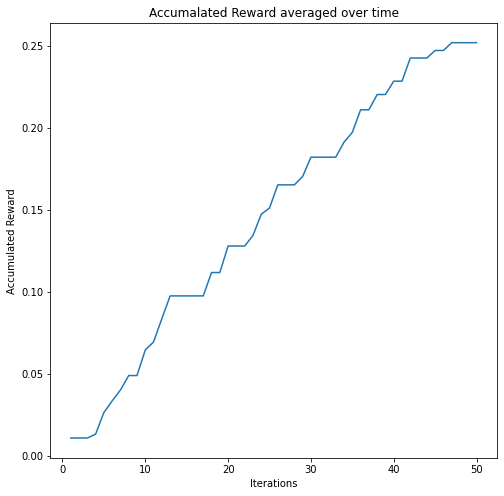

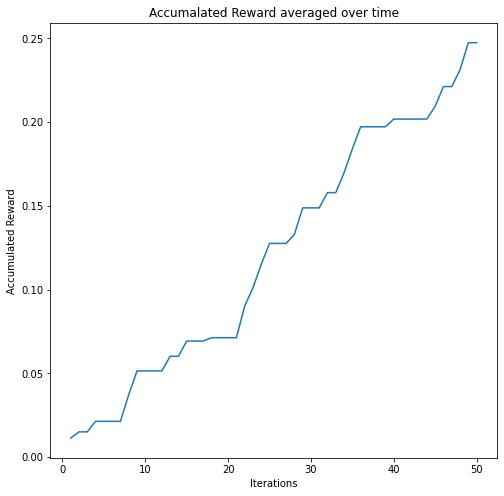

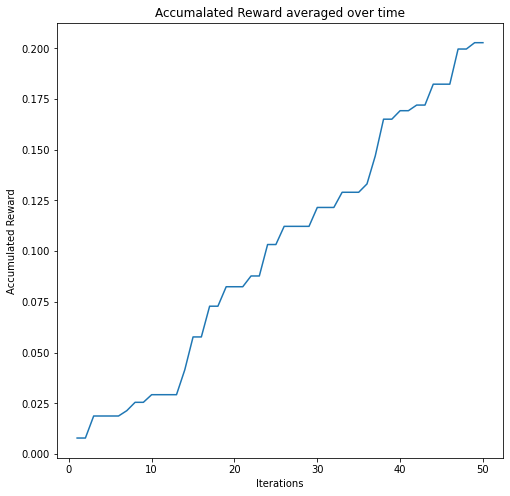

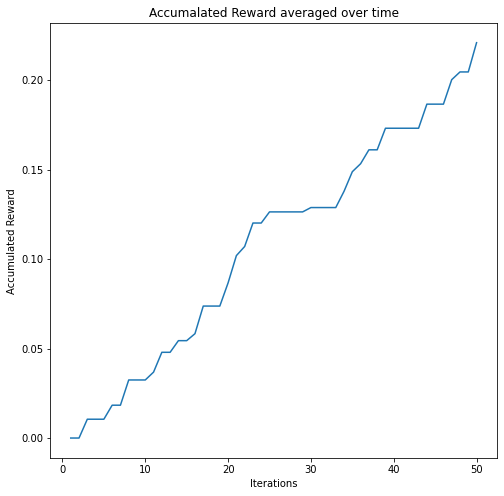

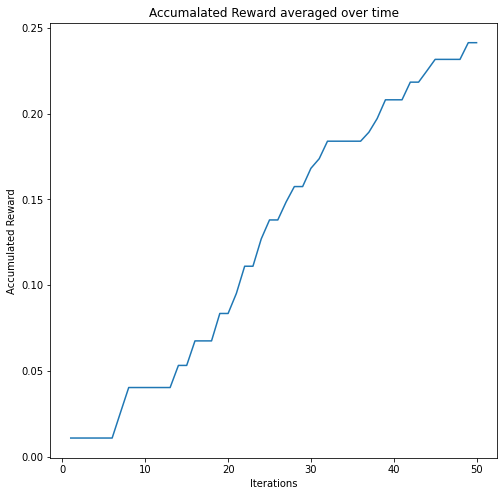

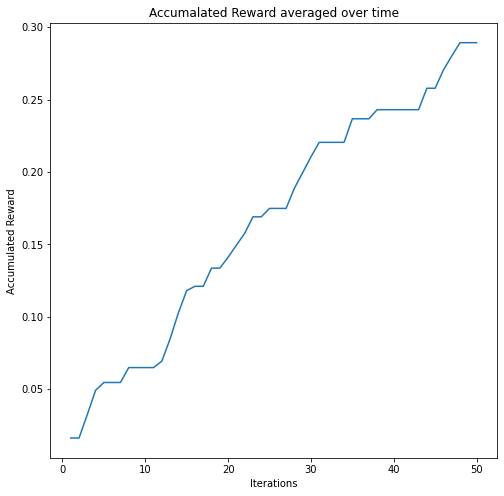

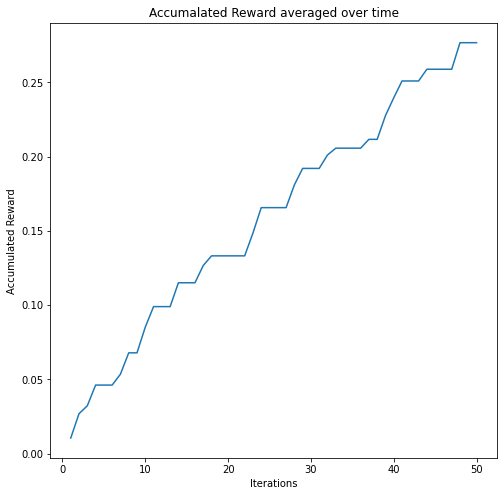

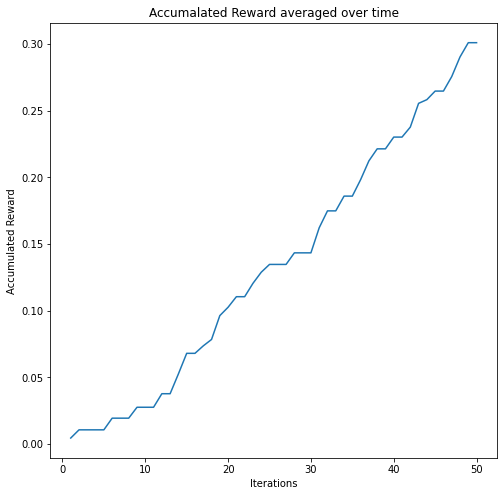

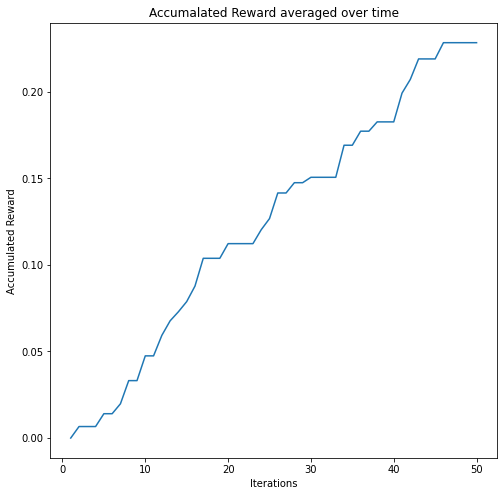

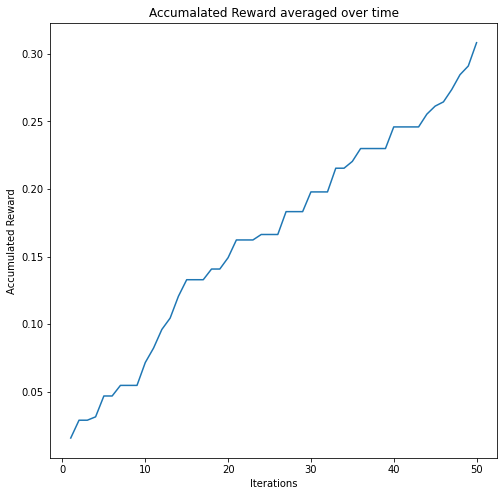

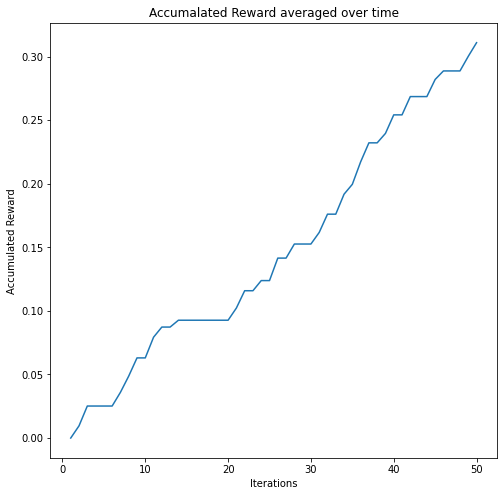

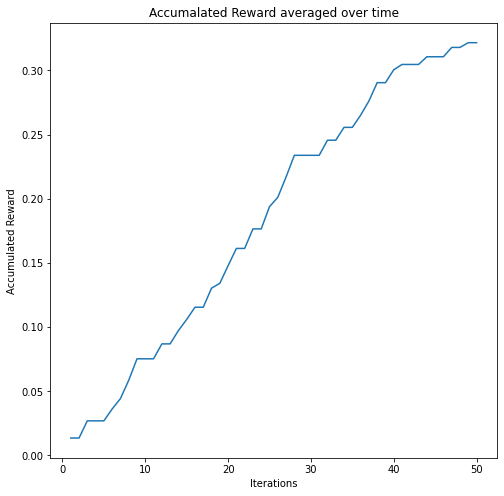

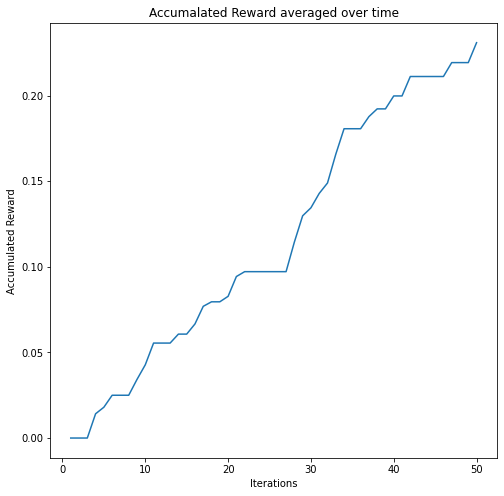

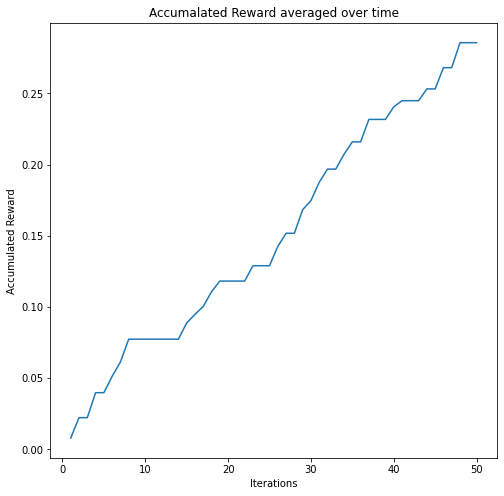

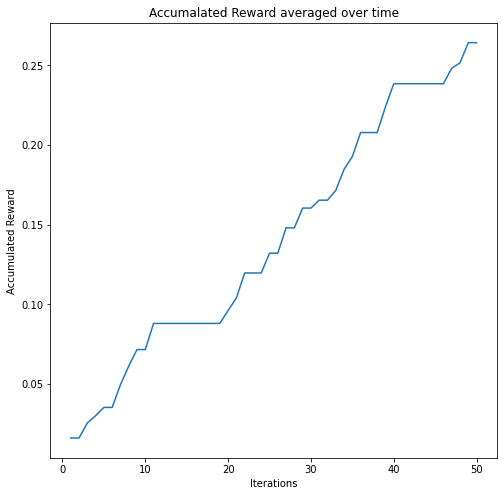

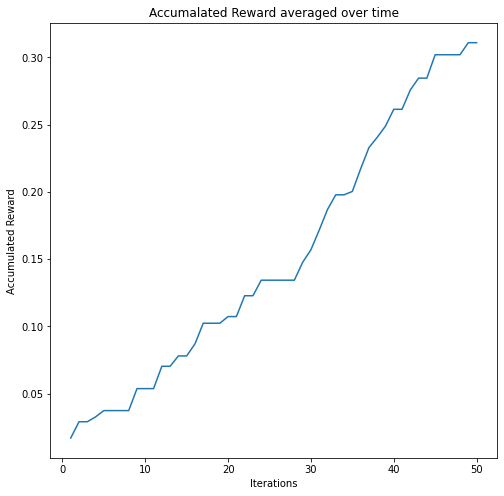

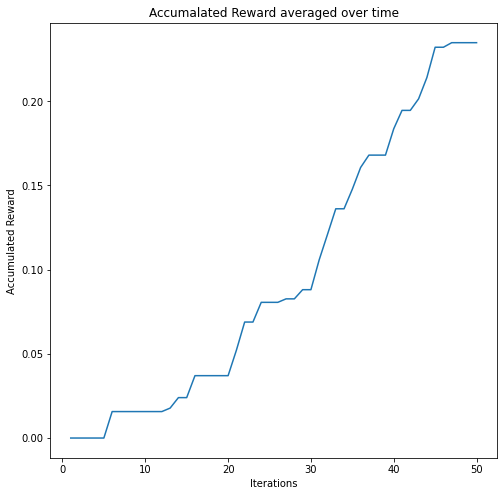

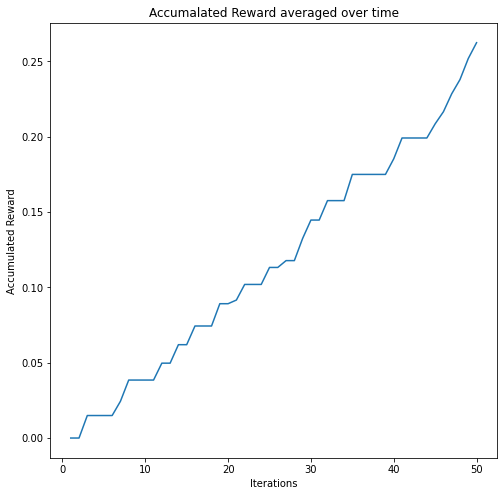

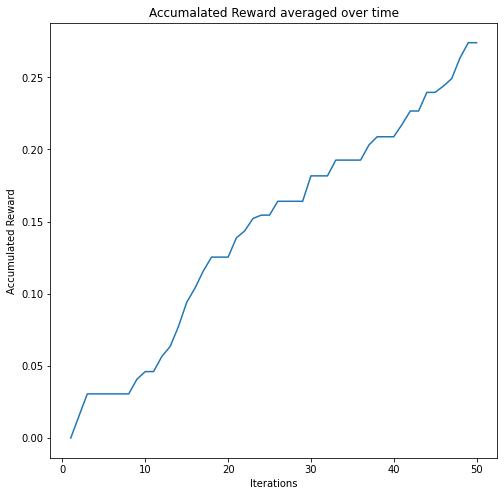

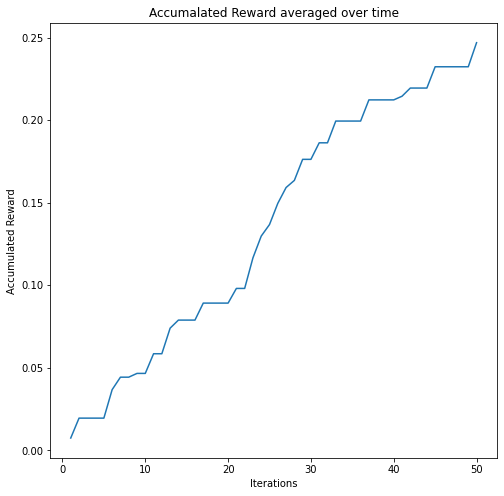

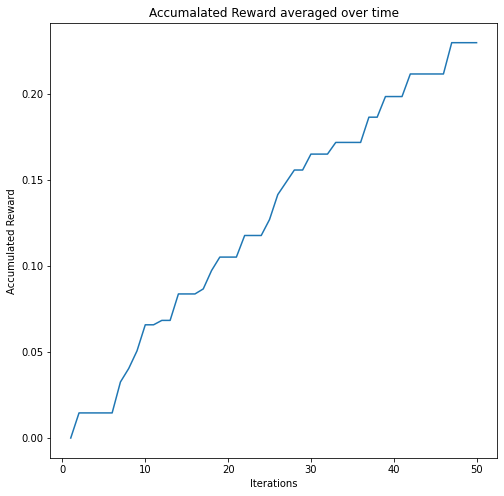

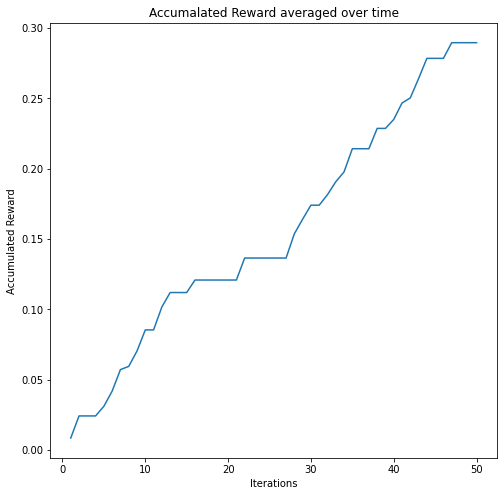

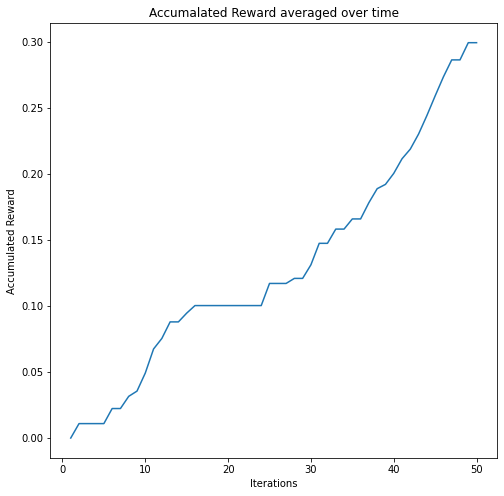

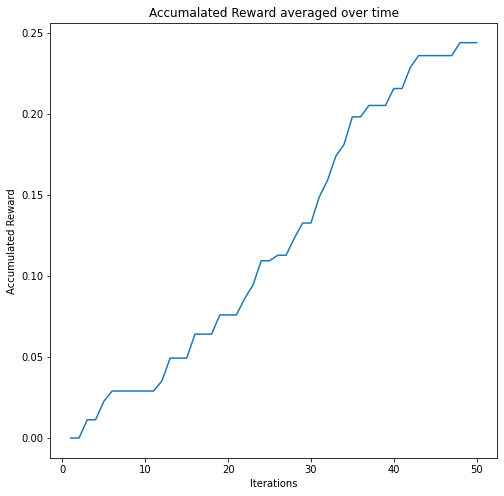

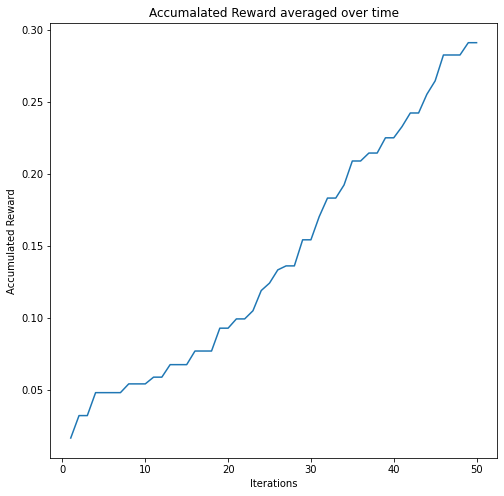

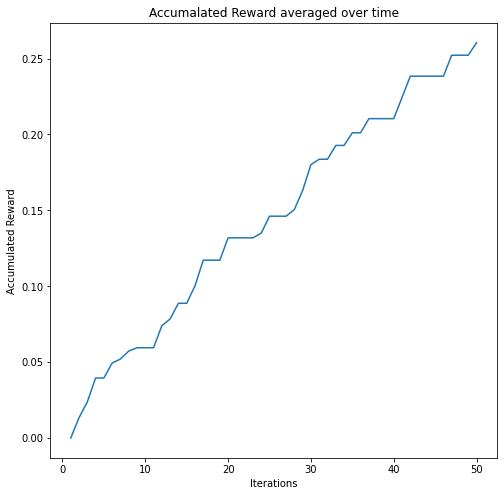

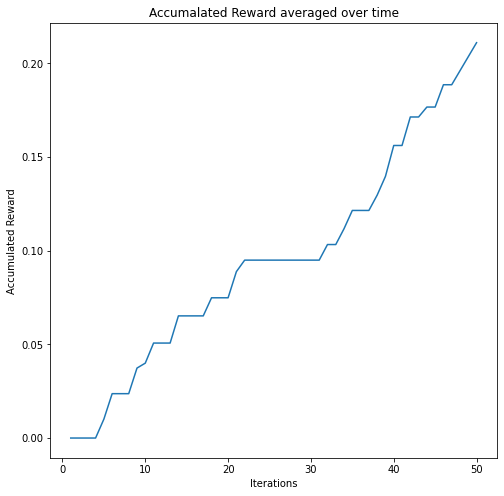

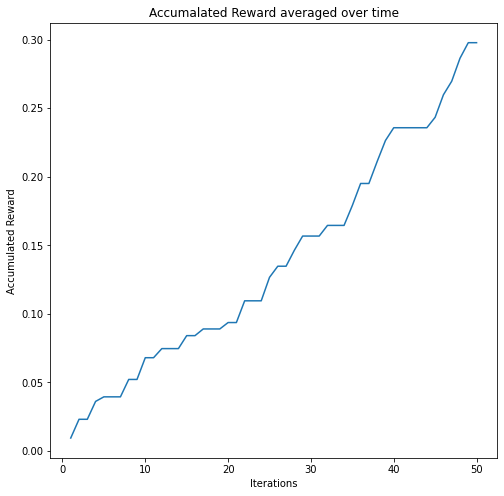

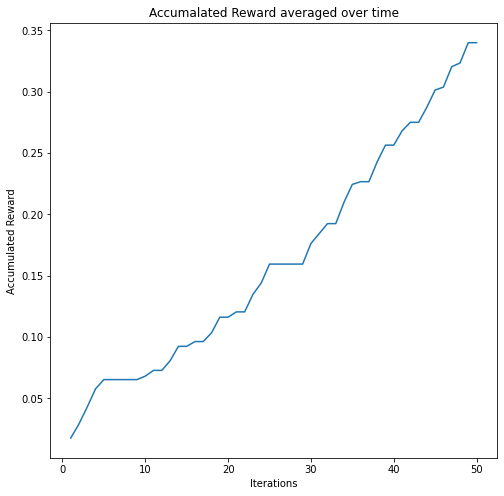

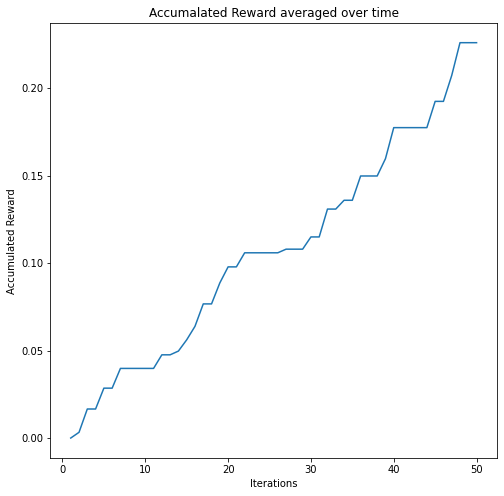

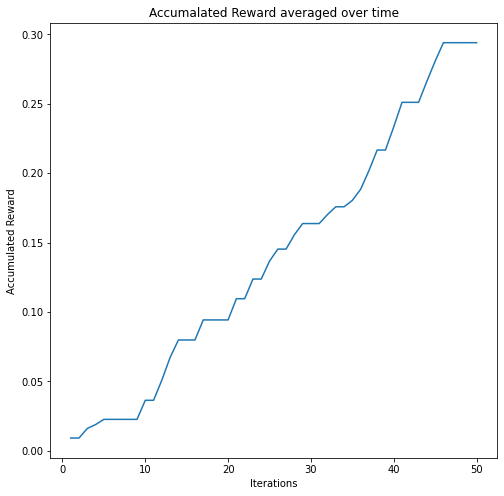

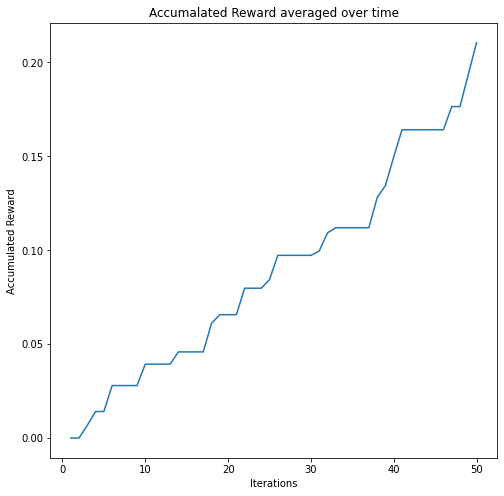

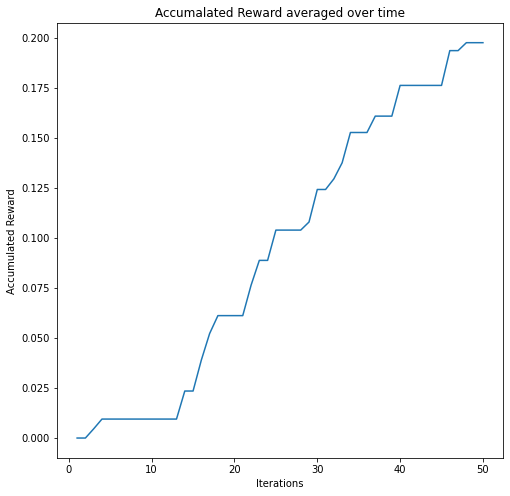

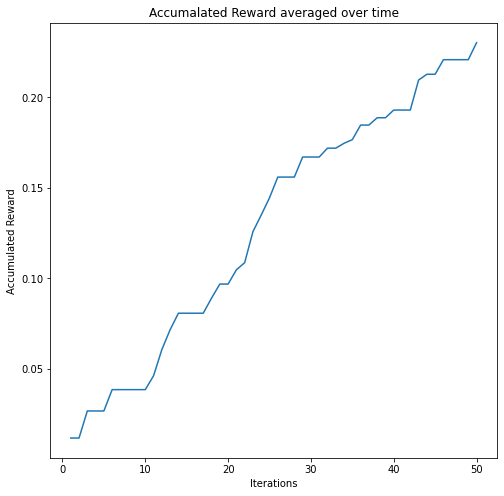

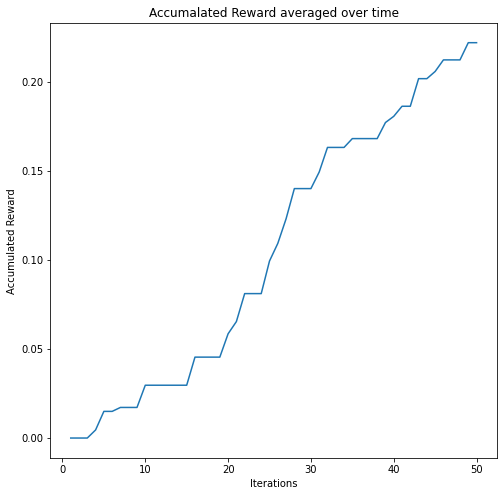

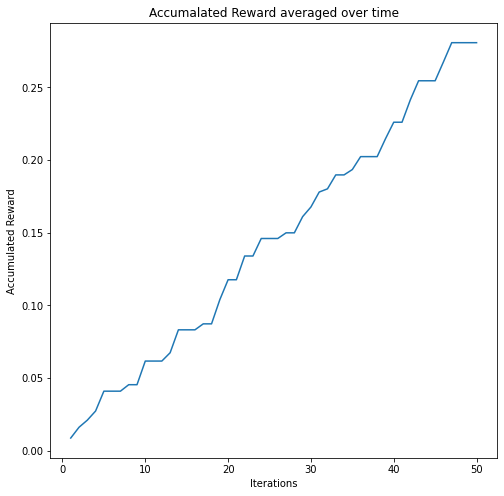

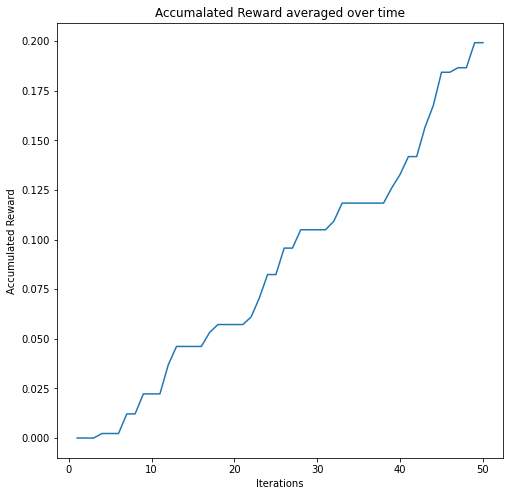

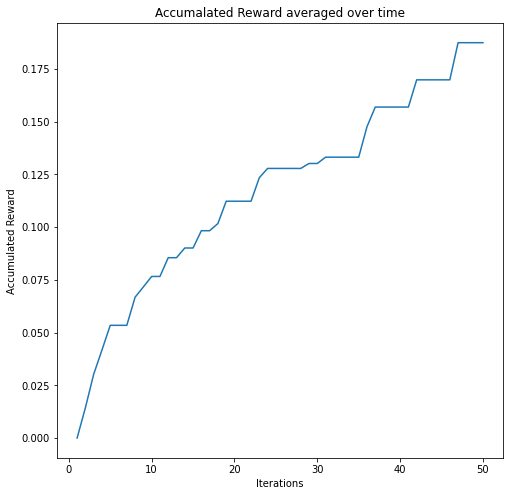

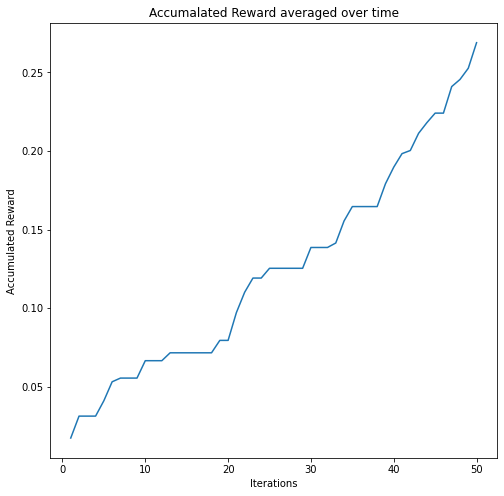

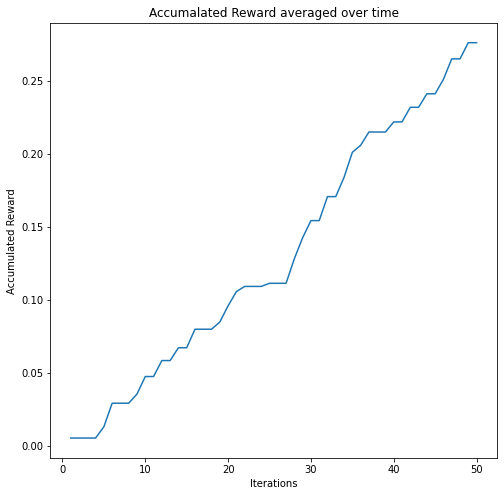

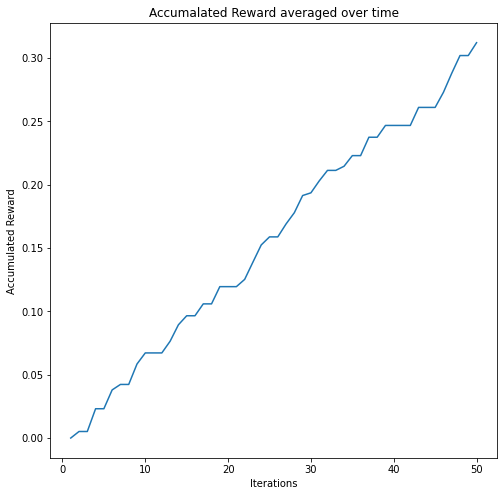

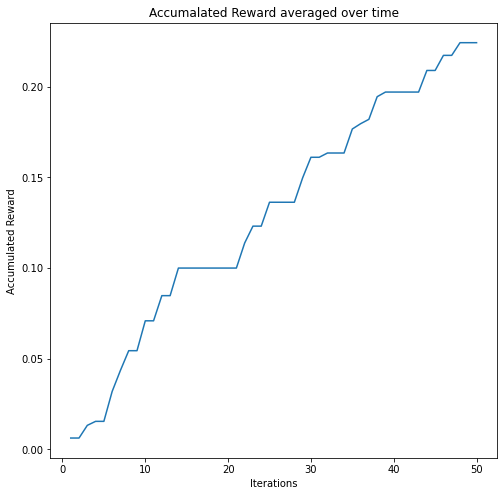

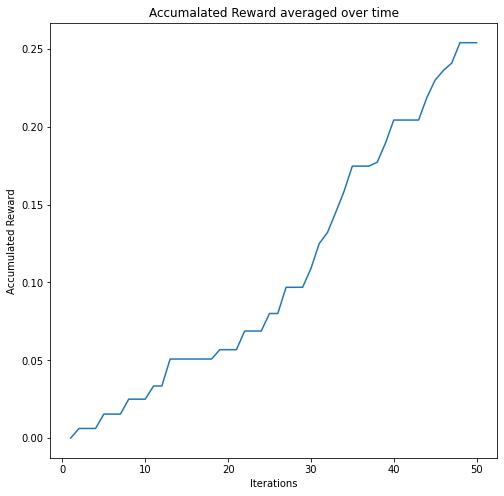

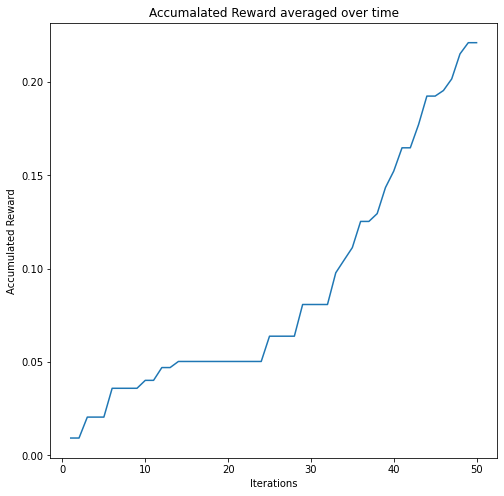

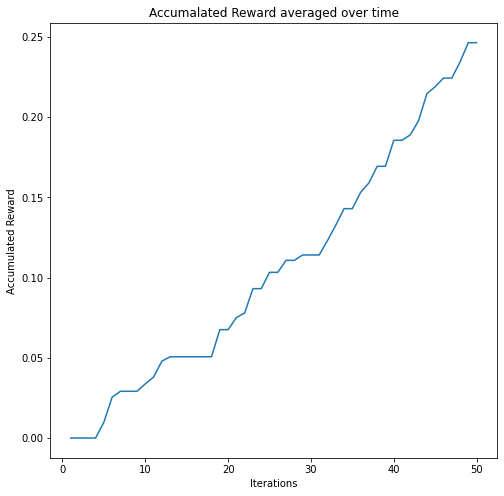

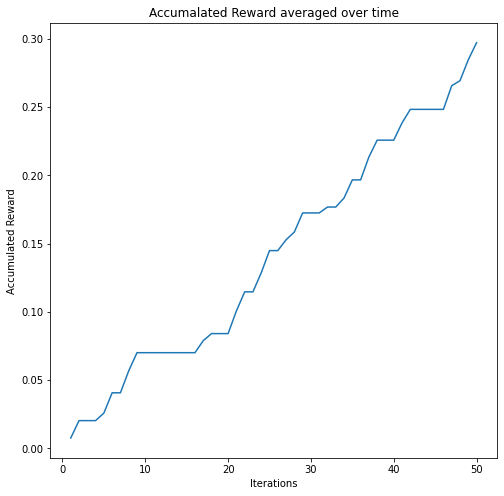

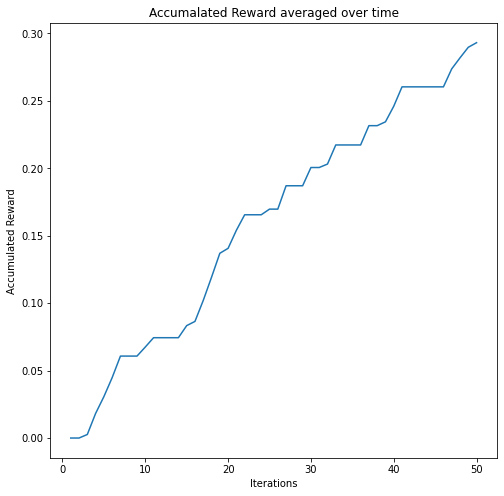

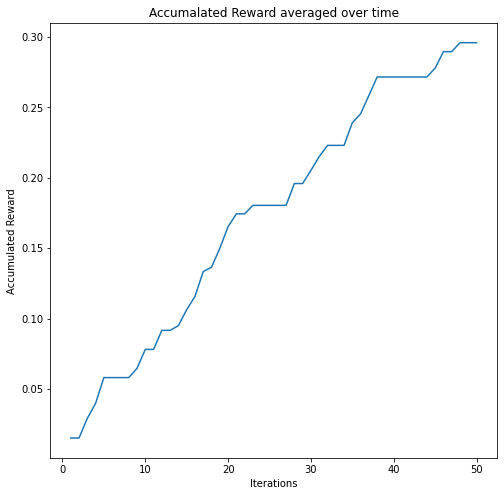

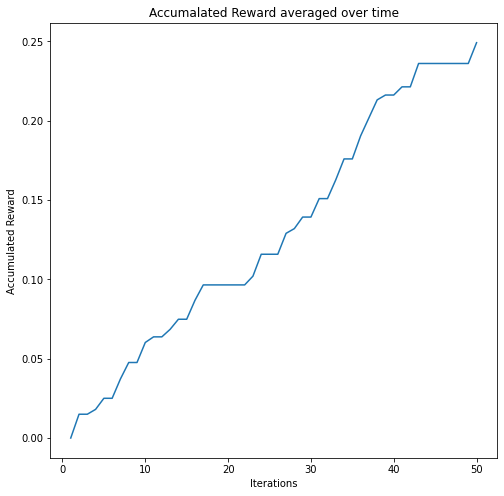

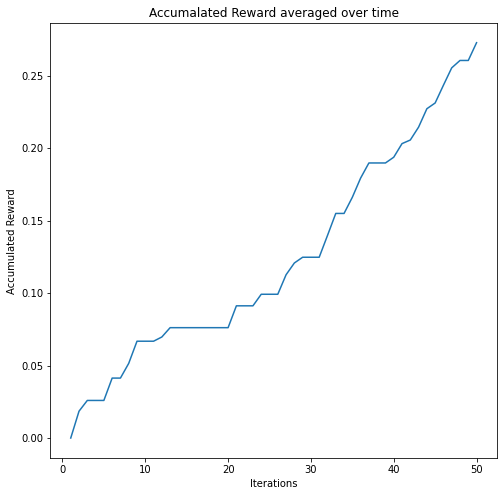

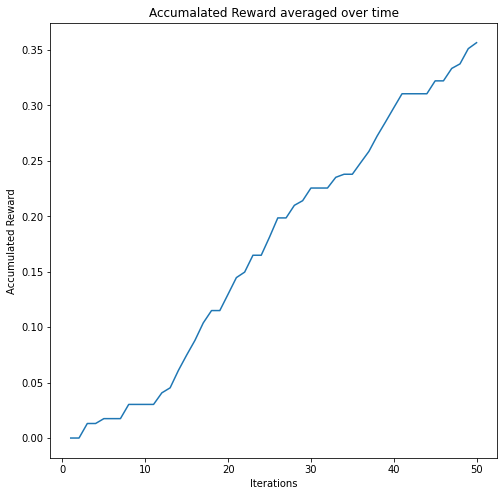

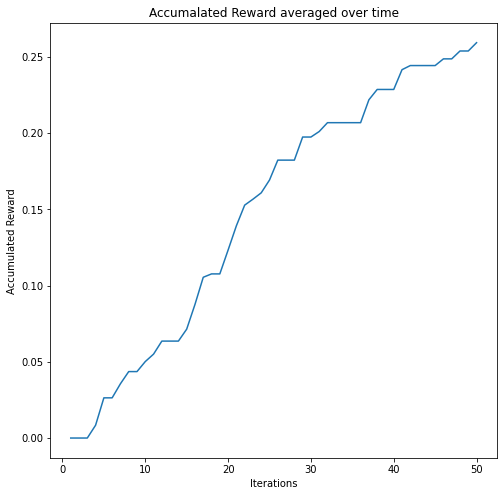

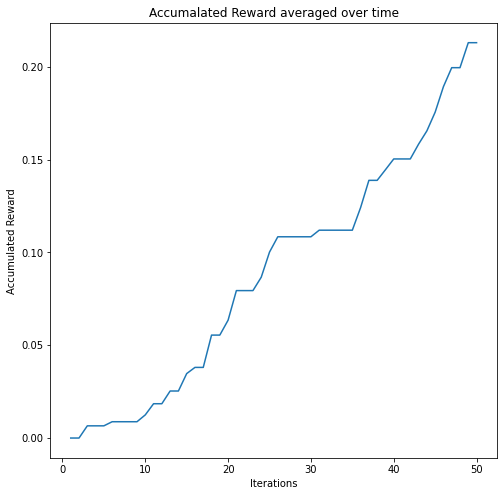

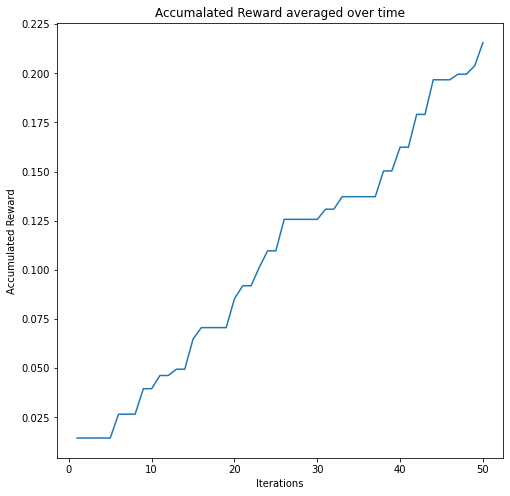

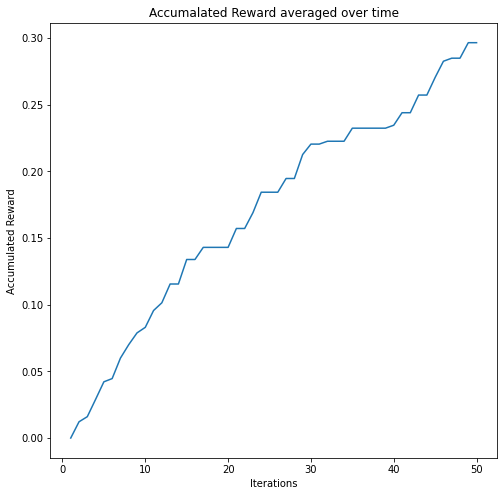

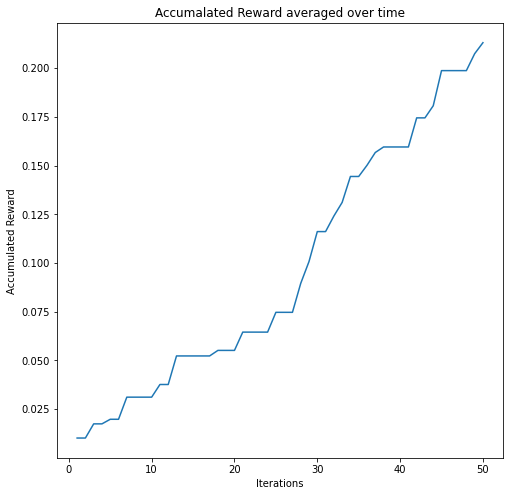

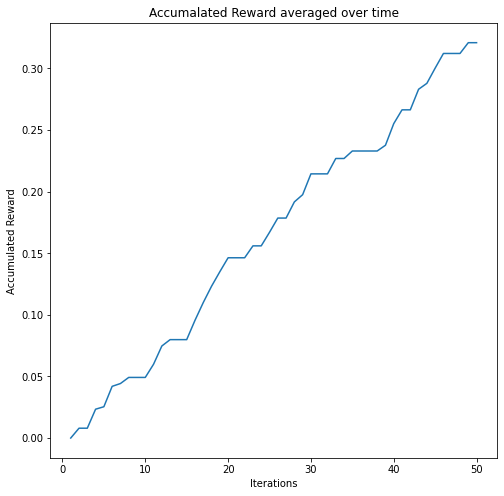

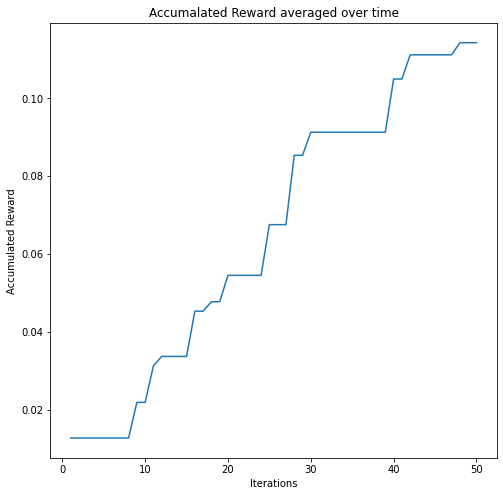

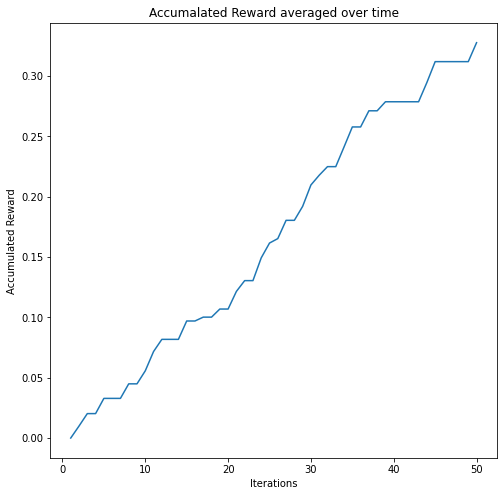

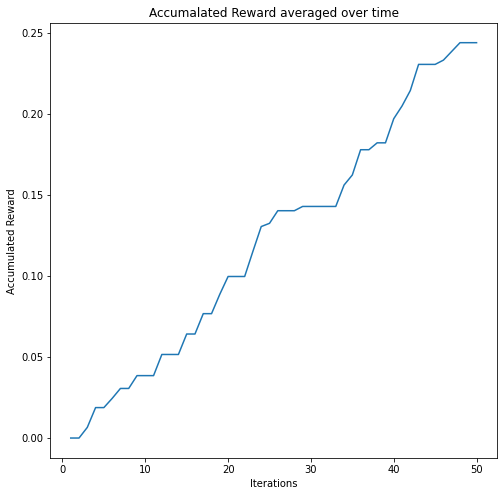

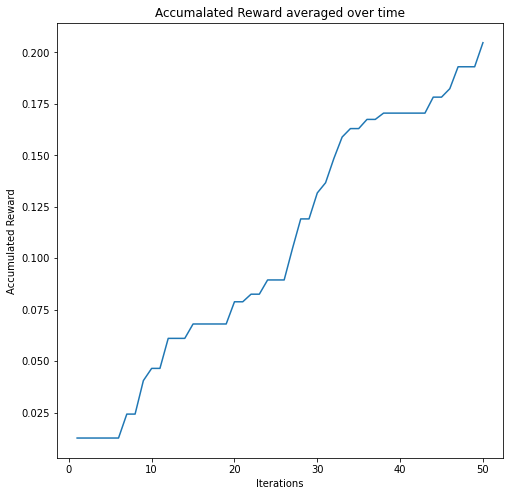

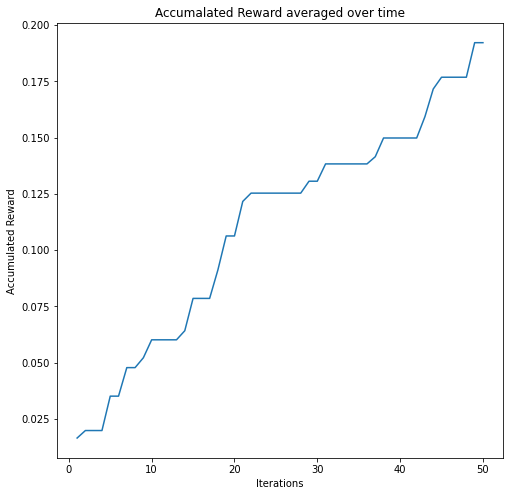

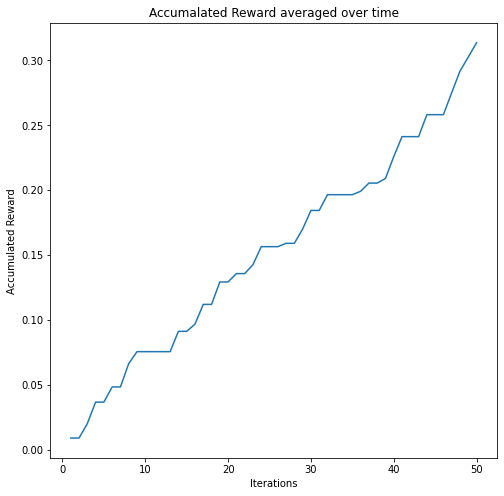

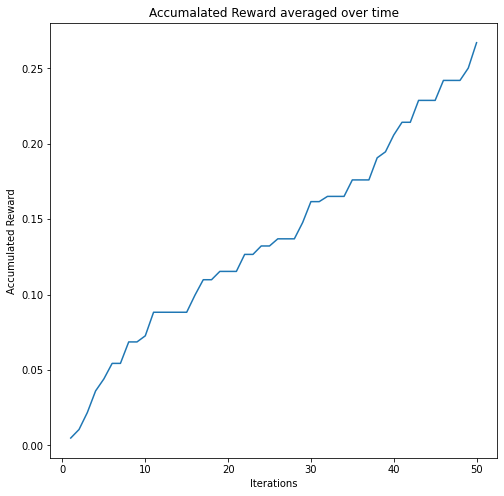

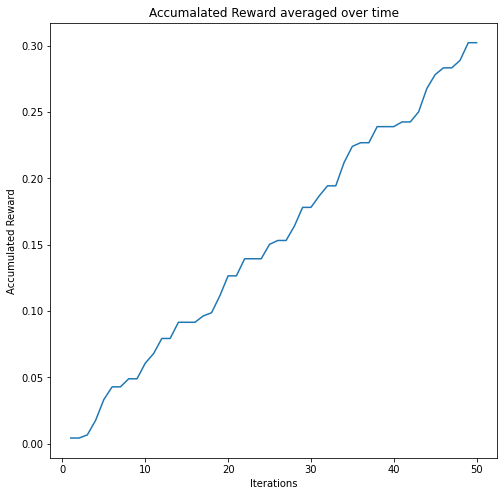

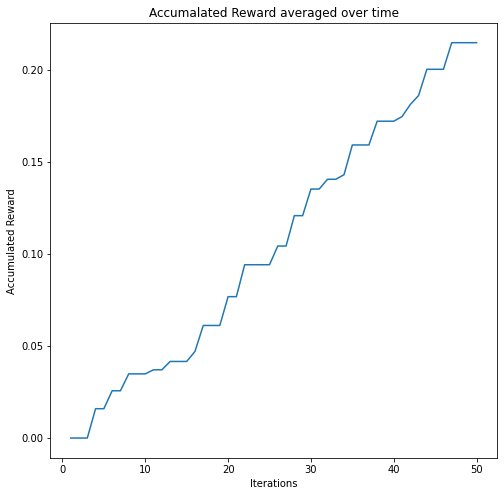

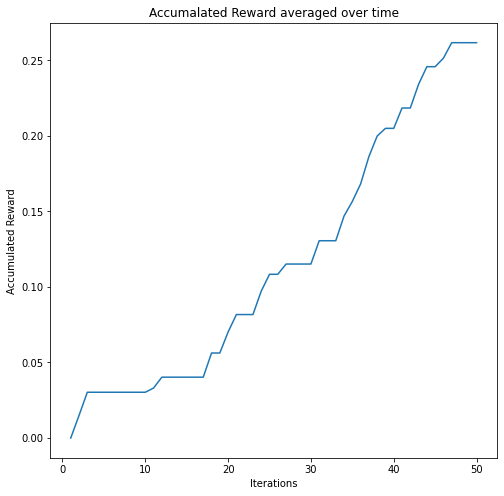

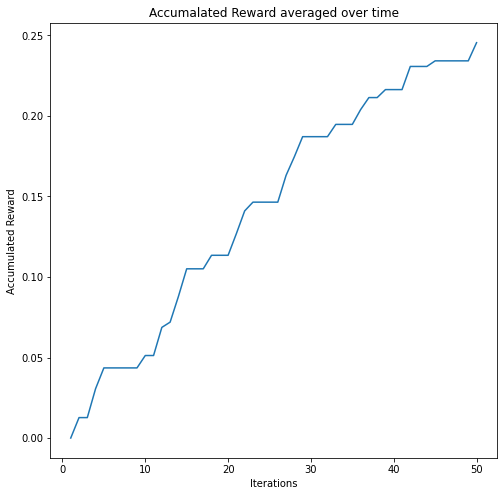

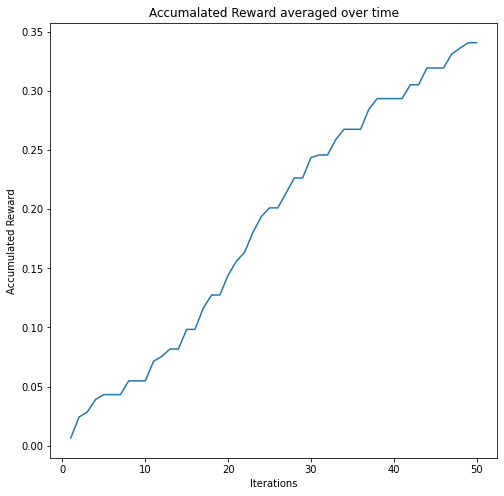

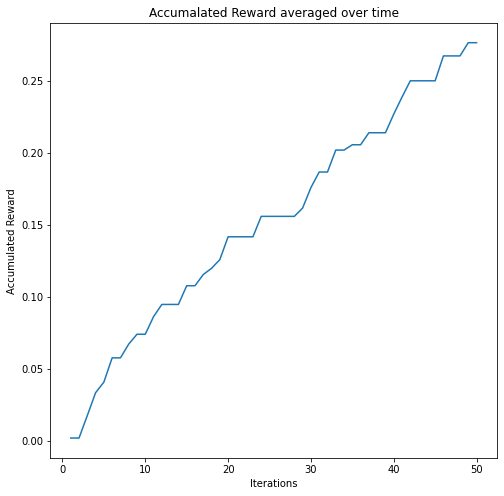

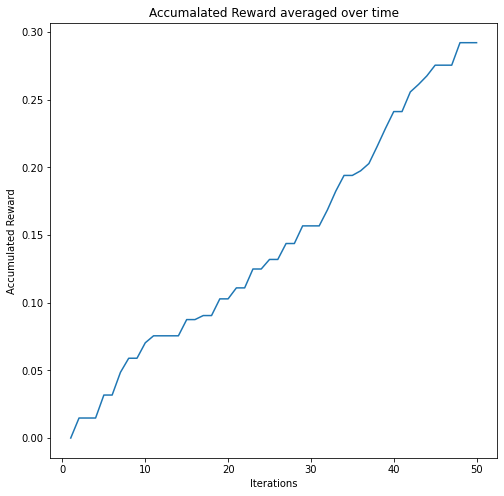

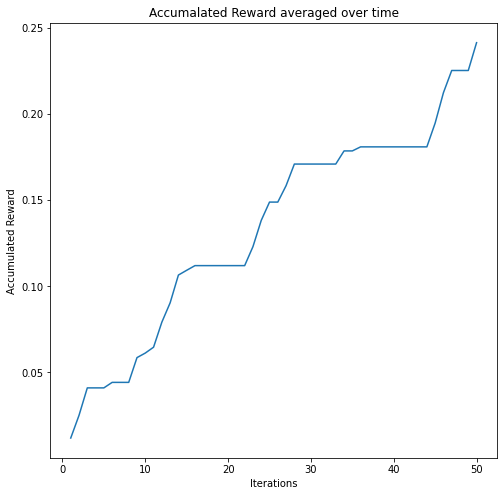

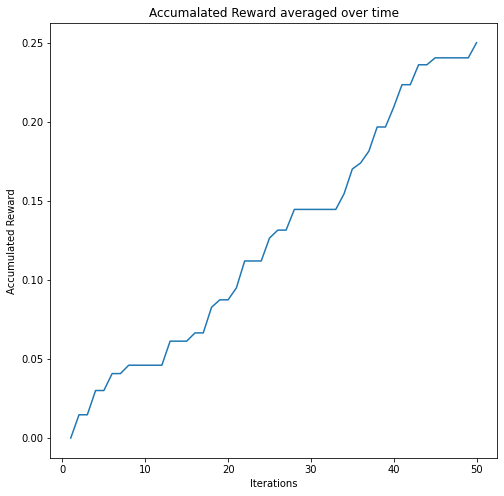

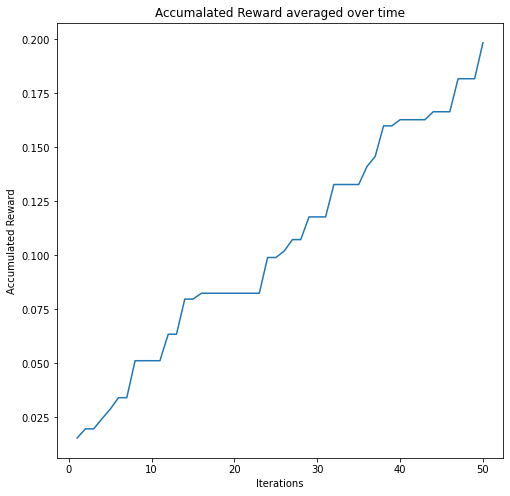

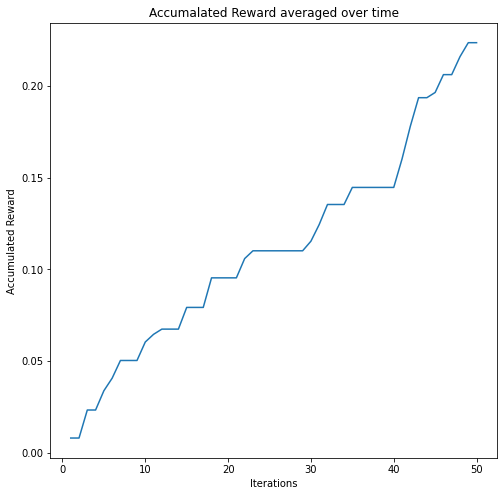

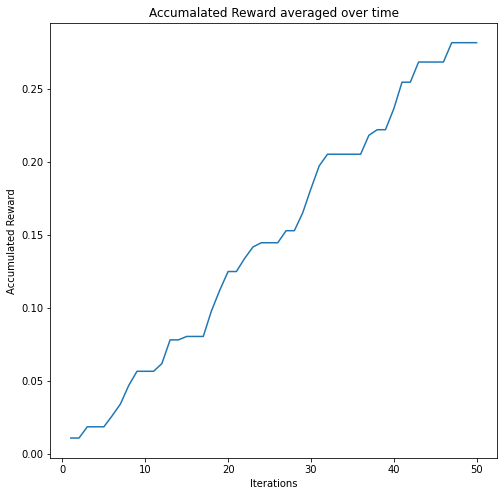

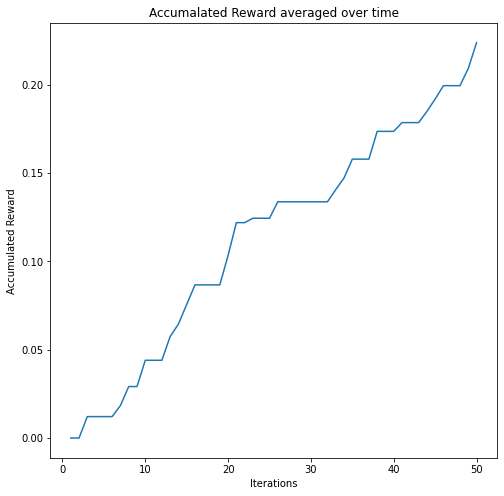

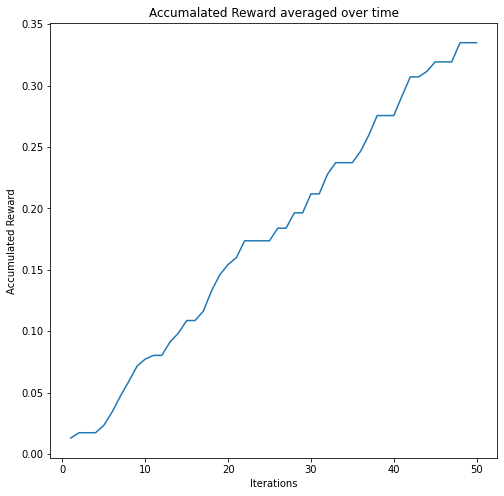

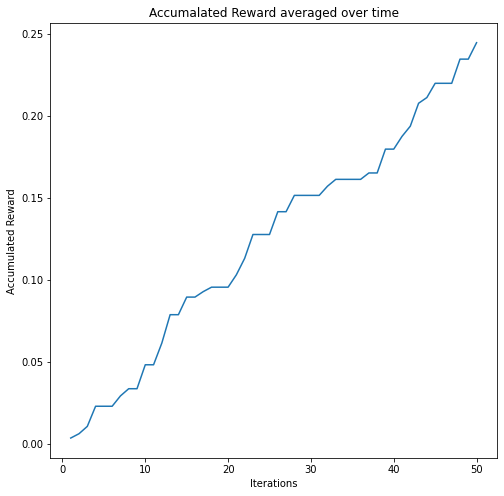

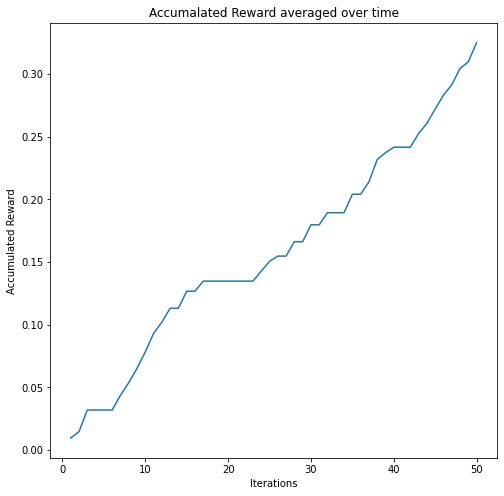

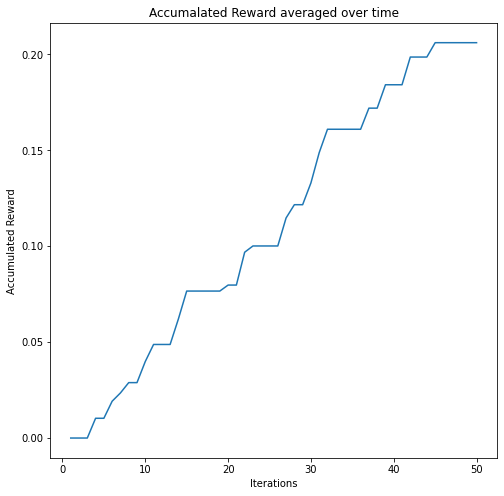

In [15]:
if __name__ == '__main__':
    main()

3 metrics to judge agent:
average reward
number of time agent reaches goal - completion rate
number of steps to reach goal

alpha -> learning rate, make sure it isn't too high -> consider when do you anneal and what point? (not important) they use 0.7
alpha below 0.1 is more correct, it just requires a lot more training episodes. 
gamma -> can make it fairly large, can even make it 1. He used 0.65 or something. Depends on learning rate as well. 
Make the number of episodes much larger so it can truly learn. E.g. 5000 or 10000